In [1]:
#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
df=pd.read_csv('demandforecastdata .csv')
df

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,17/01/11,8091,216418,99.0375,111.8625,0,0,20
1,2,17/01/11,8091,216419,99.0375,99.0375,0,0,28
2,3,17/01/11,8091,216425,133.9500,133.9500,0,0,19
3,4,17/01/11,8091,216233,133.9500,133.9500,0,0,44
4,5,17/01/11,8091,217390,141.0750,141.0750,0,0,52
...,...,...,...,...,...,...,...,...,...
150145,212638,09/07/13,9984,223245,235.8375,235.8375,0,0,38
150146,212639,09/07/13,9984,223153,235.8375,235.8375,0,0,30
150147,212642,09/07/13,9984,245338,357.6750,483.7875,1,1,31
150148,212643,09/07/13,9984,547934,141.7875,191.6625,0,1,12


In [3]:
#Preprocessing the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
record_ID          150150 non-null int64
week               150150 non-null object
store_id           150150 non-null int64
sku_id             150150 non-null int64
total_price        150149 non-null float64
base_price         150150 non-null float64
is_featured_sku    150150 non-null int64
is_display_sku     150150 non-null int64
units_sold         150150 non-null int64
dtypes: float64(2), int64(6), object(1)
memory usage: 10.3+ MB


In [4]:
df.drop(columns=['record_ID'], inplace=True)

In [5]:
df.isnull().sum()

week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [6]:
df['total_price'].value_counts()

205.9125    7048
213.0375    5272
177.4125    4544
469.5375    4489
227.2875    4150
            ... 
52.7250        1
527.2500       1
421.8000       1
496.6125       1
517.2750       1
Name: total_price, Length: 646, dtype: int64

In [7]:
df[df['total_price'].isna()]

,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,23/04/13,9436,245338,NaN,469.5375,0,0,1


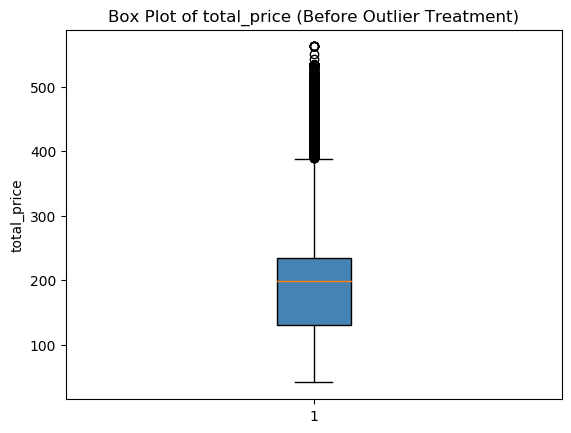

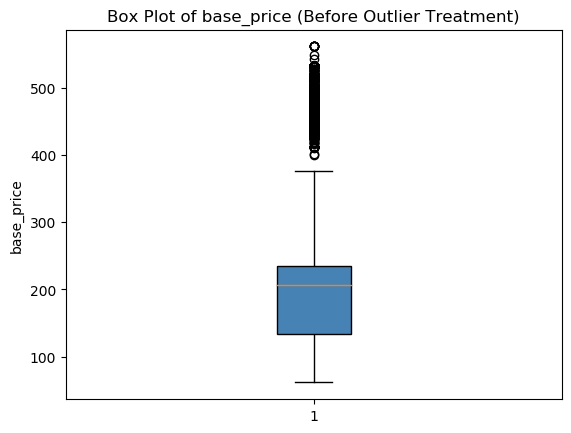

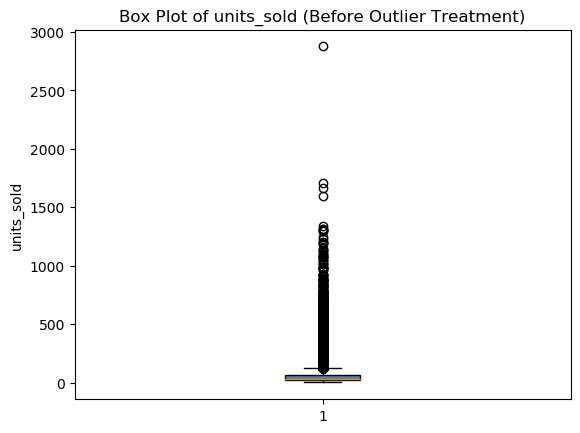

In [8]:
cols = ['total_price', 'base_price', 'units_sold']

for col in cols:
    plt.figure()
    plt.boxplot(
        df[col].dropna(),
        patch_artist=True,
        boxprops=dict(facecolor='steelblue')
    )
    plt.title(f"Box Plot of {col} (Before Outlier Treatment)")
    plt.ylabel(col)
    plt.show()

In [9]:
def remove_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    return df[(df[col] >= lower) & (df[col] <= upper)]


In [10]:
df_clean = df.copy()

for col in ['total_price', 'base_price']:
    df_clean = remove_outliers_iqr(df_clean, col)

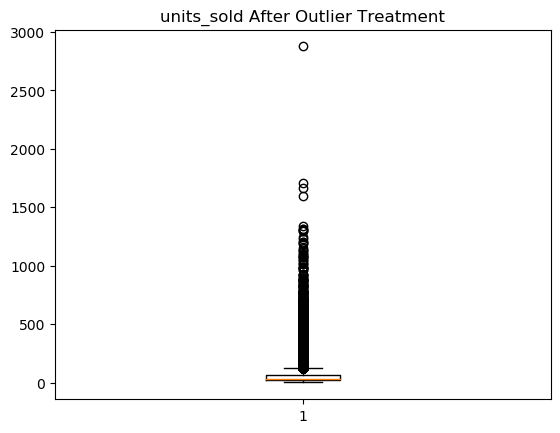

In [11]:
plt.boxplot(df['units_sold'])
plt.title('units_sold After Outlier Treatment')
plt.show()

In [12]:
upper_cap = df['units_sold'].quantile(0.99)
df['units_sold'] = df['units_sold'].clip(upper=upper_cap)

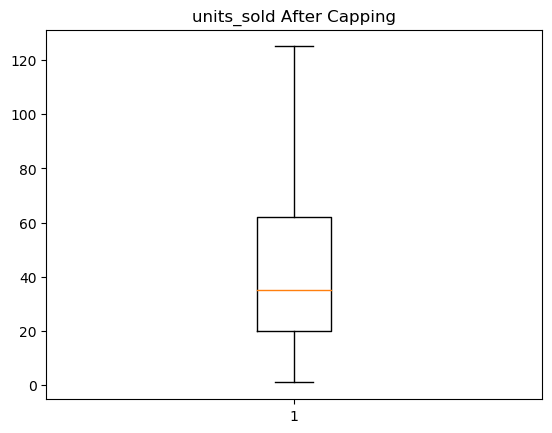

In [13]:
plt.boxplot(df['units_sold'], showfliers=False)
plt.title('units_sold After Capping')
plt.show()


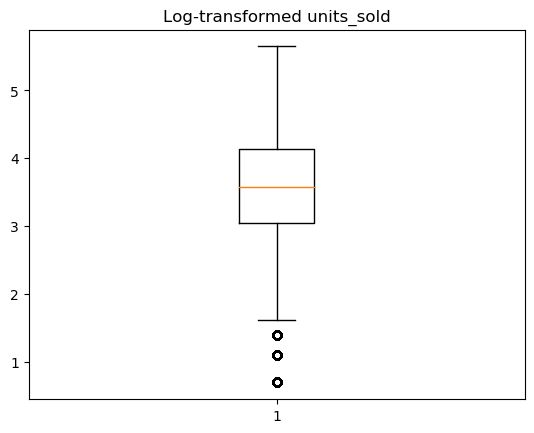

In [14]:
df['units_sold_log'] = np.log1p(df['units_sold'])

plt.boxplot(df['units_sold_log'])
plt.title('Log-transformed units_sold')
plt.show()


# Feature Engineering

In [15]:
# Convert 'week' to datetime
df_clean['week'] = pd.to_datetime(df_clean['week'], format='%d/%m/%y')

In [16]:
# Extract time-based features
df_clean['year'] = df_clean['week'].dt.year
df_clean['month'] = df_clean['week'].dt.month
df_clean['week_of_year'] = df_clean['week'].dt.week
df_clean['quarter'] = df_clean['week'].dt.quarter


In [17]:
df_clean['units_sold_roll_mean'] = df_clean.groupby(['store_id', 'sku_id'])['units_sold']\
                                            .transform(lambda x: x.rolling(window=4, min_periods=1).mean())

df['units_sold'],df_clean['units_sold_roll_mean']

(0         20
 1         28
 2         19
 3         44
 4         52
           ..
 150145    38
 150146    30
 150147    31
 150148    12
 150149    15
 Name: units_sold, Length: 150150, dtype: int64,
 0          20.00
 1          28.00
 2          19.00
 3          44.00
 4          52.00
            ...  
 150144     78.00
 150145    106.25
 150146     34.50
 150148     15.75
 150149     16.25
 Name: units_sold_roll_mean, Length: 132943, dtype: float64)

In [18]:
df.dropna(inplace=True)

In [19]:
# df['units_sold_log'] = np.log1p(df['units_sold'])
# y = df['units_sold_log']

# EDA

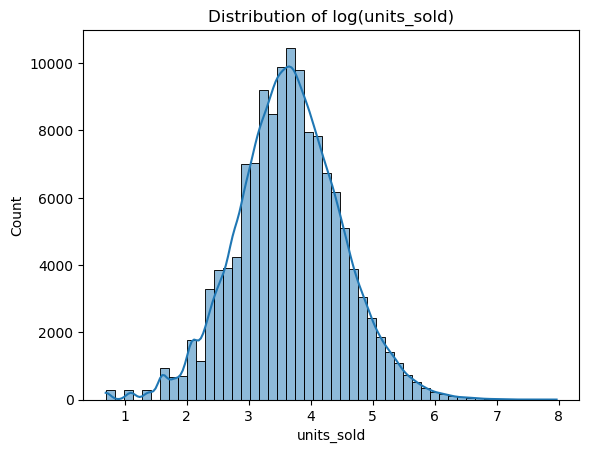

In [20]:
# Check if log transformation helps normality
plt.figure()
sns.histplot(np.log1p(df_clean['units_sold']), bins=50, kde=True)
plt.title("Distribution of log(units_sold)")
plt.show()